<a href="https://colab.research.google.com/github/LucasMirandaVS/Exerc-cios_Python/blob/main/eda_em_banco_de_dados_sqlite.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Instalando e carregando os pacotes


In [1]:
pip install -q imdb-sqlite

Pacote que executa o download dos datasets

In [2]:
!pip install -q pycountry

     |████████████████████████████████| 10.1 MB 4.6 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [3]:
import re
import time
import sqlite3
import pycountry
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from sklearn.feature_extraction.text import CountVectorizer
import warnings
warnings.filterwarnings("ignore")
sns.set_theme(style = "whitegrid")

## Carregando os dados

In [4]:
%%time
!imdb-sqlite

2022-06-01 19:57:59,462 GET https://datasets.imdbws.com/name.basics.tsv.gz -> downloads/name.basics.tsv.gz
2022-06-01 19:58:02,325 GET https://datasets.imdbws.com/title.basics.tsv.gz -> downloads/title.basics.tsv.gz
2022-06-01 19:58:04,443 GET https://datasets.imdbws.com/title.akas.tsv.gz -> downloads/title.akas.tsv.gz
2022-06-01 19:58:08,263 GET https://datasets.imdbws.com/title.principals.tsv.gz -> downloads/title.principals.tsv.gz
2022-06-01 19:58:13,561 GET https://datasets.imdbws.com/title.episode.tsv.gz -> downloads/title.episode.tsv.gz
2022-06-01 19:58:14,276 GET https://datasets.imdbws.com/title.ratings.tsv.gz -> downloads/title.ratings.tsv.gz
2022-06-01 19:58:17,157 Populating database: imdb.db
2022-06-01 19:58:17,158 Applying schema
2022-06-01 19:58:17,169 Importing file: downloads/name.basics.tsv.gz
2022-06-01 19:58:17,169 Reading number of rows ...
2022-06-01 19:58:30,130 Inserting rows into table: people
100% 11669995/11669995 [02:07<00:00, 91816.46 rows/s]
2022-06-01 20:0

In [5]:
# Conectando ao banco de dados
conn = sqlite3.connect('imdb.db')

In [6]:
# Agora posso extrair a lista de tabelas
tabelas = pd.read_sql_query("SELECT NAME AS 'Table_name' FROM sqlite_master WHERE type = 'table' ", conn)

In [7]:
# verificando o tipo de dado do objeto tabelas
type(tabelas)

pandas.core.frame.DataFrame

In [8]:
# Vendo o resultado
tabelas.head()

,Table_name
0,people
1,titles
2,akas
3,crew
4,episodes


In [9]:
# Agora convertendo o dataframe em uma lista
tabelas = tabelas["Table_name"].values.tolist()

In [10]:
# Percorrendo a lista de tabelas no banco de dados e extraindo um schema de cada uma
for tabela in tabelas:
  consulta = "PRAGMA TABLE_INFO({})".format(tabela)
  resultado = pd.read_sql_query(consulta, conn)
  print("Esquema da tabela:", tabela)
  display(resultado)
  print("-"*100)
  print("\n")

Esquema da tabela: people


,cid,name,type,notnull,dflt_value,pk
0,0,person_id,VARCHAR,0,None,1
1,1,name,VARCHAR,0,None,0
2,2,born,INTEGER,0,None,0
3,3,died,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela: titles


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,1
1,1,type,VARCHAR,0,None,0
2,2,primary_title,VARCHAR,0,None,0
3,3,original_title,VARCHAR,0,None,0
4,4,is_adult,INTEGER,0,None,0
5,5,premiered,INTEGER,0,None,0
6,6,ended,INTEGER,0,None,0
7,7,runtime_minutes,INTEGER,0,None,0
8,8,genres,VARCHAR,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela: akas


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,0
1,1,title,VARCHAR,0,None,0
2,2,region,VARCHAR,0,None,0
3,3,language,VARCHAR,0,None,0
4,4,types,VARCHAR,0,None,0
5,5,attributes,VARCHAR,0,None,0
6,6,is_original_title,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela: crew


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,0
1,1,person_id,VARCHAR,0,None,0
2,2,category,VARCHAR,0,None,0
3,3,job,VARCHAR,0,None,0
4,4,characters,VARCHAR,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela: episodes


,cid,name,type,notnull,dflt_value,pk
0,0,episode_title_id,INTEGER,0,None,0
1,1,show_title_id,INTEGER,0,None,0
2,2,season_number,INTEGER,0,None,0
3,3,eposide_number,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela: ratings


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,1
1,1,rating,INTEGER,0,None,0
2,2,votes,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------




Agora vou pra EDA e as perguntas de negócio

## 1 - Quais são as categorias de filmes mais comuns no IMDB?

In [11]:
# Definindo a consulta
consulta1 = '''SELECT type, COUNT (*) AS COUNT FROM titles GROUP BY type'''

In [12]:
# Extraindo os dados
resultado1 = pd.read_sql_query(consulta1, conn)

In [13]:
display(resultado1)

,type,COUNT
0,movie,611416
1,short,871954
2,tvEpisode,6730368
3,tvMiniSeries,43597
4,tvMovie,136261
5,tvPilot,2
6,tvSeries,225777
7,tvShort,10554
8,tvSpecial,37136
9,video,261146


In [14]:
# Adicionando o percentual de cada tipo
resultado1['Percentual'] = (resultado1['COUNT']/resultado1['COUNT'].sum())*100
display(resultado1)

,type,COUNT,Percentual
0,movie,611416,6.824251
1,short,871954,9.732216
2,tvEpisode,6730368,75.120242
3,tvMiniSeries,43597,0.486603
4,tvMovie,136261,1.520862
5,tvPilot,2,0.000022
6,tvSeries,225777,2.519984
7,tvShort,10554,0.117797
8,tvSpecial,37136,0.414489
9,video,261146,2.914752


In [15]:
# Agora para a vizualização do resultado: Vou separar em 6 categorias
# Others contém o resto dos resultados

# Primeiro um dicionário vazio pro resto dos filmes
others = {}

# Agora filtrando o percentual em 5% e somando o total
others['COUNT'] = resultado1[resultado1['Percentual'] < 2.0]['COUNT'].sum()

# Gravando o percentual também
others['Percentual'] = resultado1[resultado1['Percentual'] < 2.0]['Percentual'].sum()

# Ajustando o nome
others['type'] = 'others'


In [16]:
others

{'COUNT': 258799, 'Percentual': 2.8885557834958804, 'type': 'others'}

In [17]:
# Filtrando o dataframe de resultado
resultado1 = resultado1[resultado1['Percentual'] > 1]

In [18]:
# Agora um append com as outras categorias
resultado1 = resultado1.append(others, ignore_index = True)

In [19]:
# Ordenando o resultado 
resultado1 = resultado1.sort_values(by = 'COUNT', ascending = False)

In [20]:
resultado1.head()

,type,COUNT,Percentual
2,tvEpisode,6730368,75.120242
1,short,871954,9.732216
0,movie,611416,6.824251
5,video,261146,2.914752
6,others,258799,2.888556


In [21]:
# Ajustando as labels
labels = [str(resultado1['type'][i])+' '+'['+str(round(resultado1['Percentual'][i],2)) +'%'+']' for i in resultado1.index]

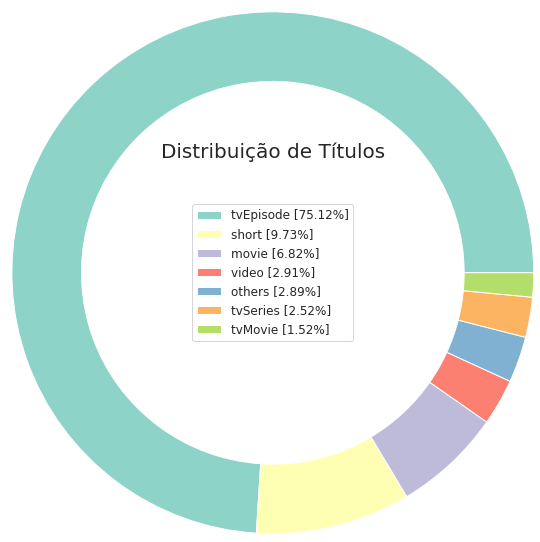

In [22]:
# Plotando os resultados
cs = cm.Set3(np.arange(100))

# Cria a figura
f = plt.figure()

# Pie Plot
plt.pie(resultado1['COUNT'], labeldistance = 1, radius = 3, colors = cs, wedgeprops = dict(width = 0.8))
plt.legend(labels = labels, loc = 'center', prop = {'size':12})
plt.title("Distribuição de Títulos", loc = 'Center', fontdict = {'fontsize':20,'fontweight':20})
plt.show()

Evidentemente, os epísódios de séries são mais numerosos por que cada obra tem mais de um episódio, ao contrario dos filmes. O surpreendete foi ver que os filmes estão em menor número até que os curtas!

## 2- Qual o Número de Títulos Por Gênero?

Calculando o número de filmes por gênero e entregando o resultado em valor percentual.

In [23]:
# Criando a consulta
consulta2 = '''SELECT genres, COUNT(*) FROM titles WHERE type = 'movie' GROUP BY genres'''

In [24]:
# Resultado
resultado2 = pd.read_sql_query(consulta2, conn)

In [25]:
display(resultado2)

,genres,COUNT(*)
0,Action,14044
1,"Action,Adult",11
2,"Action,Adult,Adventure",1
3,"Action,Adult,Comedy",5
4,"Action,Adult,Crime",10
...,...,...
1459,"Thriller,Western",43
1460,War,1301
1461,"War,Western",14
1462,Western,5158


In [26]:
# Convertendo as strings para minúsculo
resultado2['genres'] = resultado2['genres'].str.lower().values


In [27]:
# Removendo os valores NA 
temp = resultado2['genres'].dropna()

In [28]:
# Criando um vetor usando expressão regular para filtrar as strings
padrao = '(?u)\\b[\\w-]+\\b'
vetor = CountVectorizer(token_pattern = padrao, analyzer = 'word').fit(temp)
type(vetor)

sklearn.feature_extraction.text.CountVectorizer

In [29]:
# Aplicando a vetorização ao dataset sem NA
bag_generos = vetor.transform(temp)
type(bag_generos)

scipy.sparse.csr.csr_matrix

In [30]:
# Como eu so quer valores unicos, vou declarar o obj
generos_unicos =  vetor.get_feature_names()

In [31]:
# Visualizando o dataframe de gêneros
generos = pd.DataFrame(bag_generos.todense(), columns = generos_unicos, index = temp.index)
generos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1464 entries, 0 to 1463
Data columns (total 29 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   action       1464 non-null   int64
 1   adult        1464 non-null   int64
 2   adventure    1464 non-null   int64
 3   animation    1464 non-null   int64
 4   biography    1464 non-null   int64
 5   comedy       1464 non-null   int64
 6   crime        1464 non-null   int64
 7   documentary  1464 non-null   int64
 8   drama        1464 non-null   int64
 9   family       1464 non-null   int64
 10  fantasy      1464 non-null   int64
 11  film-noir    1464 non-null   int64
 12  game-show    1464 non-null   int64
 13  history      1464 non-null   int64
 14  horror       1464 non-null   int64
 15  music        1464 non-null   int64
 16  musical      1464 non-null   int64
 17  mystery      1464 non-null   int64
 18  n            1464 non-null   int64
 19  news         1464 non-null   int64
 20  reality-

In [32]:
# Dropando essa coluna  que apareceu
generos = generos.drop(columns = 'n', axis = 0)

In [33]:
# Calculando o percentual de novo
generos_percentual = 100 * pd.Series(generos.sum()).sort_values(ascending = False) / generos.shape[0]

In [34]:
# Visualizando
generos_percentual.head(10)

drama          17.964481
comedy         16.871585
documentary    15.778689
adventure      14.890710
action         14.412568
romance        13.251366
crime          13.114754
mystery        12.500000
thriller       12.295082
fantasy        12.090164
dtype: float64

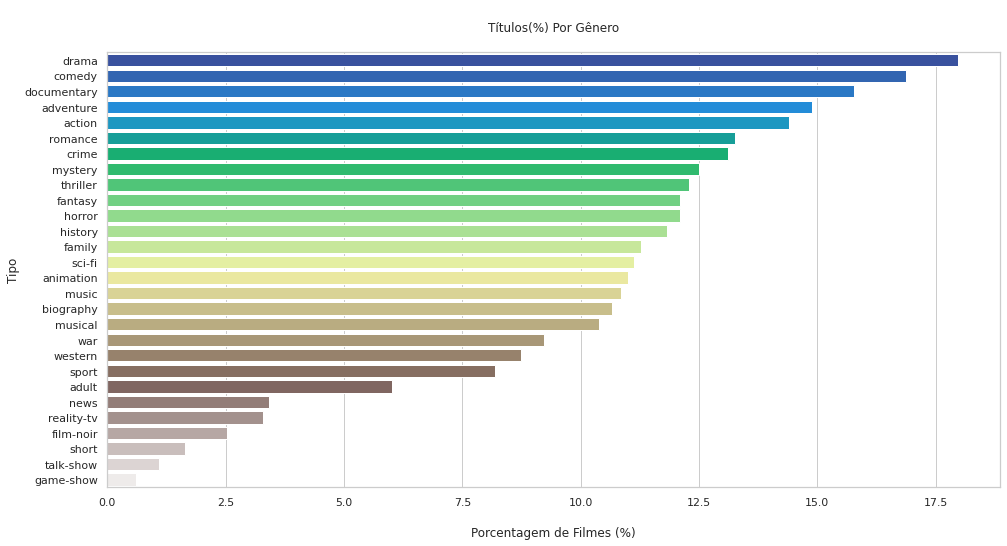

In [35]:
# Plot
plt.figure(figsize = (16,8))
sns.barplot(x = generos_percentual.values, y = generos_percentual.index, orient = "h", palette = "terrain")
plt.ylabel('Tipo')             
plt.xlabel("\nPorcentagem de Filmes (%)")
plt.title('\nTítulos(%) Por Gênero\n')
plt.show()

## 3- Quais as principais tendencias de avaliação dos filmes por gênero?

Vou calcular e visualizar as medianas de avaliação

In [36]:
# Consulta SQL
consulta3 = '''
            SELECT rating, genres FROM 
            ratings JOIN titles ON ratings.title_id = titles.title_id 
            WHERE premiered <= 2022 AND type = 'movie'
            ''' 

In [37]:
# Resultado
resultado3 = pd.read_sql_query(consulta3, conn)
display(resultado3)

,rating,genres
0,4.5,\N
1,6.0,"Action,Adventure,Biography"
2,4.5,Drama
3,4.5,Drama
4,3.9,Drama
...,...,...
278876,5.8,Thriller
278877,6.4,"Drama,History"
278878,3.8,"Adventure,History,War"
278879,8.3,Drama


In [38]:
# Criando uma função para retornar os genêros
def retorna_generos(df):
    df['genres'] = df['genres'].str.lower().values
    temp = df['genres'].dropna()
    vetor = CountVectorizer(token_pattern = '(?u)\\b[\\w-]+\\b', analyzer = 'word').fit(temp)
    generos_unicos =  vetor.get_feature_names()
    generos_unicos = [genre for genre in generos_unicos if len(genre) > 1]
    return generos_unicos

In [39]:
# Aplica a função
generos_unicos = retorna_generos(resultado3)
generos_unicos

['action',
 'adult',
 'adventure',
 'animation',
 'biography',
 'comedy',
 'crime',
 'documentary',
 'drama',
 'family',
 'fantasy',
 'film-noir',
 'game-show',
 'history',
 'horror',
 'music',
 'musical',
 'mystery',
 'news',
 'reality-tv',
 'romance',
 'sci-fi',
 'short',
 'sport',
 'talk-show',
 'thriller',
 'war',
 'western']

In [40]:
# Cria listas vazias
genero_counts = []
genero_ratings = []

In [41]:
# Loop
for item in generos_unicos:
    
    # Contando os filmes por gênero
    consulta = 'SELECT COUNT(rating) FROM ratings JOIN titles ON ratings.title_id=titles.title_id WHERE genres LIKE '+ '\''+'%'+item+'%'+'\' AND type=\'movie\''
    resultado = pd.read_sql_query(consulta, conn)
    genero_counts.append(resultado.values[0][0])
  
     # Avaliação de filmes por gênero
    consulta = 'SELECT rating FROM ratings JOIN titles ON ratings.title_id=titles.title_id WHERE genres LIKE '+ '\''+'%'+item+'%'+'\' AND type=\'movie\''
    resultado = pd.read_sql_query(consulta, conn)
    genero_ratings.append(np.median(resultado['rating']))

In [42]:
# Dataframe final
df_genero_ratings = pd.DataFrame()
df_genero_ratings['genres'] = generos_unicos
df_genero_ratings['count'] = genero_counts
df_genero_ratings['rating'] = genero_ratings

In [43]:
df_genero_ratings.head(20)

,genres,count,rating
0,action,28875,5.8
1,adult,4377,5.8
2,adventure,17515,6.0
3,animation,4789,6.5
4,biography,8498,7.0
5,comedy,68916,6.0
6,crime,23854,6.1
7,documentary,41749,7.3
8,drama,123519,6.3
9,family,10772,6.3


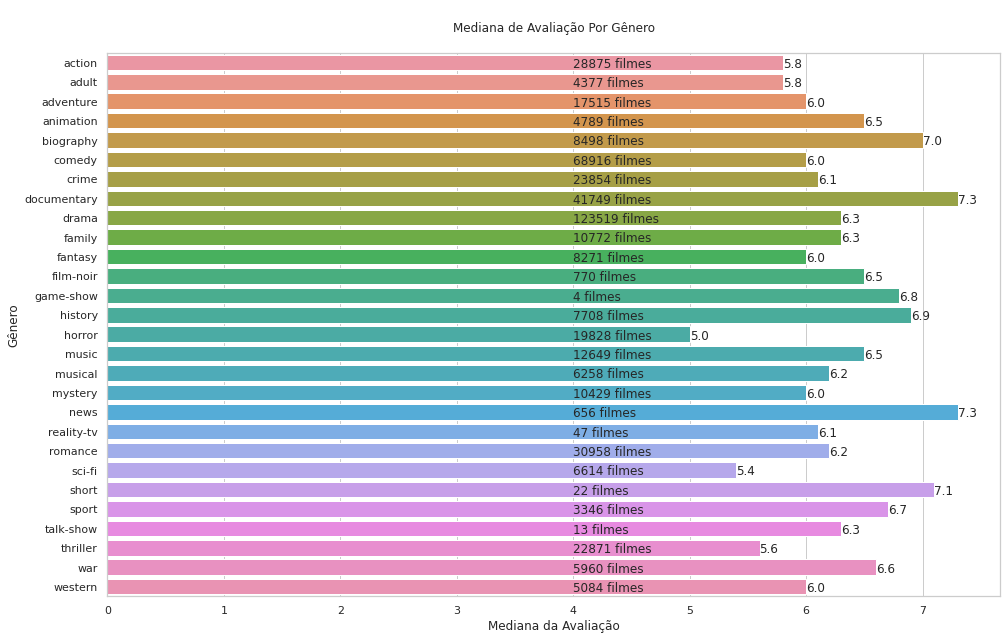

In [44]:
# Plot da figura
plt.figure(figsize = (16,10))

# Barplot
sns.barplot(y = df_genero_ratings.genres, x = df_genero_ratings.rating, orient = "h")

# Textos do gráfico
for i in range(len(df_genero_ratings.index)):
    
    plt.text(4.0, 
             i + 0.25, 
             str(df_genero_ratings['count'][df_genero_ratings.index[i]]) + " filmes")
    
    plt.text(df_genero_ratings.rating[df_genero_ratings.index[i]],
             i + 0.25,
             round(df_genero_ratings["rating"][df_genero_ratings.index[i]],2))

plt.ylabel('Gênero')             
plt.xlabel('Mediana da Avaliação')
plt.title('\nMediana de Avaliação Por Gênero\n')
plt.show()


## 4- Qual a mediana de avaliação dos filmes no ano de estréia?

Mediana novamente

In [45]:
# Consulta SQL
consulta4 = '''
            SELECT rating AS Rating, premiered FROM 
            ratings JOIN titles ON ratings.title_id = titles.title_id 
            WHERE premiered <= 2022 AND type = 'movie'
            ORDER BY premiered
            ''' 

In [46]:
resultado4 = pd.read_sql_query(consulta4, conn)
display(resultado4)

,Rating,premiered
0,6.7,1896
1,4.5,1897
2,4.0,1899
3,3.7,1899
4,6.0,1900
...,...,...
278876,7.6,2022
278877,9.5,2022
278878,7.2,2022
278879,5.0,2022


In [47]:
#Calculando a mediana ao longo do tempo
ratings = []
for year in set(resultado4['premiered']):
    ratings.append(np.median(resultado4[resultado4['premiered'] == year]['Rating']))
# Conferindo o tipo
type(ratings)

list

In [48]:
# Listando de anos
anos = list(set(resultado4['premiered']))

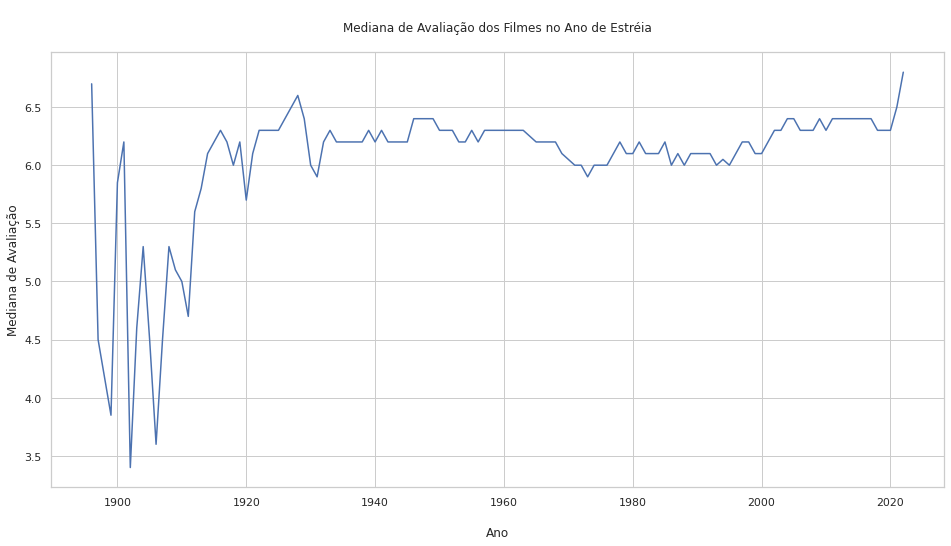

In [49]:
# Plot
plt.figure(figsize = (16,8))
plt.plot(anos, ratings)
plt.xlabel('\nAno')
plt.ylabel('Mediana de Avaliação')
plt.title('\nMediana de Avaliação dos Filmes no Ano de Estréia\n')
plt.show()

## 5- Qual o Número de Filmes Avaliados Por Gênero Em Relação ao Ano de Estréia?

Número de filmes por gênero. 

In [50]:
# Consulta SQL
consulta5 = '''SELECT genres FROM titles ''' 

In [51]:
# Resultado
resultado5 = pd.read_sql_query(consulta5, conn)
display(resultado5)

,genres
0,"Documentary,Short"
1,"Animation,Short"
2,"Animation,Comedy,Romance"
3,"Animation,Short"
4,"Comedy,Short"
...,...
8959455,"Action,Drama,Family"
8959456,"Action,Drama,Family"
8959457,"Action,Drama,Family"
8959458,Short


In [52]:
# Retorna gêneros únicos usando a função feita antes
generos_unicos = retorna_generos(resultado5)
generos_unicos

['action',
 'adult',
 'adventure',
 'animation',
 'biography',
 'comedy',
 'crime',
 'documentary',
 'drama',
 'family',
 'fantasy',
 'film-noir',
 'game-show',
 'history',
 'horror',
 'music',
 'musical',
 'mystery',
 'news',
 'reality-tv',
 'romance',
 'sci-fi',
 'short',
 'sport',
 'talk-show',
 'thriller',
 'war',
 'western']

In [53]:
# Agora a contagem
genero_count = []
for item in generos_unicos:
    consulta = 'SELECT COUNT(*) COUNT FROM  titles  WHERE genres LIKE '+ '\''+'%'+item+'%'+'\' AND type=\'movie\' AND premiered <= 2022'
    resultado = pd.read_sql_query(consulta, conn)
    genero_count.append(resultado['COUNT'].values[0])

In [54]:
# Juntando em um o dataframe
df_genero_count = pd.DataFrame()
df_genero_count['genre'] = generos_unicos
df_genero_count['Count'] = genero_count

In [55]:
# Top 5
df_genero_count = df_genero_count[df_genero_count['genre'] != 'n']
df_genero_count = df_genero_count.sort_values(by = 'Count', ascending = False)
top_generos = df_genero_count.head()['genre'].values

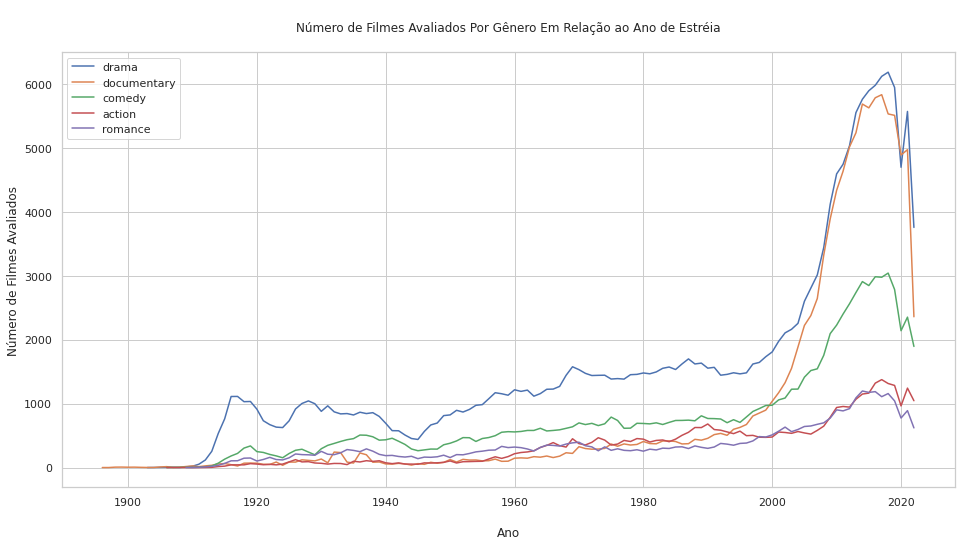

In [56]:
# Plot
plt.figure(figsize = (16,8))

# Loop pro plot
for item in top_generos:
    consulta = 'SELECT COUNT(*) Number_of_movies, premiered Year FROM  titles  WHERE genres LIKE '+ '\''+'%'+item+'%'+'\' AND type=\'movie\' AND Year <=2022 GROUP BY Year'
    resultado = pd.read_sql_query(consulta, conn)
    plt.plot(resultado['Year'], resultado['Number_of_movies'])

plt.xlabel('\nAno')
plt.ylabel('Número de Filmes Avaliados')
plt.title('\nNúmero de Filmes Avaliados Por Gênero Em Relação ao Ano de Estréia\n')
plt.legend(labels = top_generos)
plt.show()


## 6- Qual o filme mais longo da amostra?

Além disso vou verificar os percentis.



In [57]:
consulta6 = '''
            SELECT runtime_minutes Runtime 
            FROM titles 
            WHERE type = 'movie' AND Runtime != 'NaN'
            ''' 

In [58]:
resultado6 = pd.read_sql_query(consulta6, conn)
display(resultado6)

,Runtime
0,100
1,70
2,90
3,120
4,58
...,...
385114,123
385115,57
385116,100
385117,116


In [59]:
# Esse loop calcula os percentis
for i in range(101): 
    val = i
    perc = round(np.percentile(resultado6['Runtime'].values, val), 2)
    print('{} percentil da duração (runtime) é: {}'.format(val, perc))

0 percentil da duração (runtime) é: 1.0
1 percentil da duração (runtime) é: 45.0
2 percentil da duração (runtime) é: 47.0
3 percentil da duração (runtime) é: 50.0
4 percentil da duração (runtime) é: 50.0
5 percentil da duração (runtime) é: 51.0
6 percentil da duração (runtime) é: 52.0
7 percentil da duração (runtime) é: 53.0
8 percentil da duração (runtime) é: 55.0
9 percentil da duração (runtime) é: 56.0
10 percentil da duração (runtime) é: 57.0
11 percentil da duração (runtime) é: 59.0
12 percentil da duração (runtime) é: 60.0
13 percentil da duração (runtime) é: 60.0
14 percentil da duração (runtime) é: 60.0
15 percentil da duração (runtime) é: 61.0
16 percentil da duração (runtime) é: 63.0
17 percentil da duração (runtime) é: 64.0
18 percentil da duração (runtime) é: 66.0
19 percentil da duração (runtime) é: 67.0
20 percentil da duração (runtime) é: 69.0
21 percentil da duração (runtime) é: 70.0
22 percentil da duração (runtime) é: 70.0
23 percentil da duração (runtime) é: 72.0
24 

Tecnicamente, o percentil 100 ja é a resposta, mas da pra apresentar isso de outra forma.

In [60]:
# Vou refazer a query pra me retornar o nome do filme
consulta6 = '''
            SELECT runtime_minutes Runtime, primary_title
            FROM titles 
            WHERE type = 'movie' AND Runtime != 'NaN'
            ORDER BY Runtime DESC
            LIMIT 1
            ''' 

In [61]:
resultado6 = pd.read_sql_query(consulta6, conn)
display(resultado6) # Esse é o filme mais longo da amostra!

,Runtime,primary_title
0,51420,Logistics


## 7- Quais os géneros mais longos? e os mais curtos?

Relação entre duração do filme e gênero.

In [63]:
# Criando a consulta no banco SQLite
consulta7 = '''
            SELECT AVG(runtime_minutes) Runtime, genres 
            FROM titles 
            WHERE type = 'movie'
            AND runtime_minutes != 'NaN'
            GROUP BY genres
            ''' 

In [64]:
# Resultado
resultado7 = pd.read_sql_query(consulta7, conn)

In [66]:
# Aplicando de novo a função de géneros únicos
generos_unicos = retorna_generos(resultado7)
generos_unicos

['action',
 'adult',
 'adventure',
 'animation',
 'biography',
 'comedy',
 'crime',
 'documentary',
 'drama',
 'family',
 'fantasy',
 'film-noir',
 'game-show',
 'history',
 'horror',
 'music',
 'musical',
 'mystery',
 'news',
 'reality-tv',
 'romance',
 'sci-fi',
 'short',
 'sport',
 'talk-show',
 'thriller',
 'war',
 'western']

In [67]:
# Função que calcula duração por gênero
genero_runtime = []
for item in generos_unicos:
    consulta = 'SELECT runtime_minutes Runtime FROM  titles  WHERE genres LIKE '+ '\''+'%'+item+'%'+'\' AND type=\'movie\' AND Runtime!=\'NaN\''
    resultado = pd.read_sql_query(consulta, conn)
    genero_runtime.append(np.median(resultado['Runtime']))

In [68]:
# Prepara o dataframe
df_genero_runtime = pd.DataFrame()
df_genero_runtime['genre'] = generos_unicos
df_genero_runtime['runtime'] = genero_runtime

In [69]:
# Tirando o índice 'news'
df_genero_runtime = df_genero_runtime.drop(index = 18)

In [70]:
# Ordena os dados
df_genero_runtime = df_genero_runtime.sort_values(by = 'runtime', ascending = False)

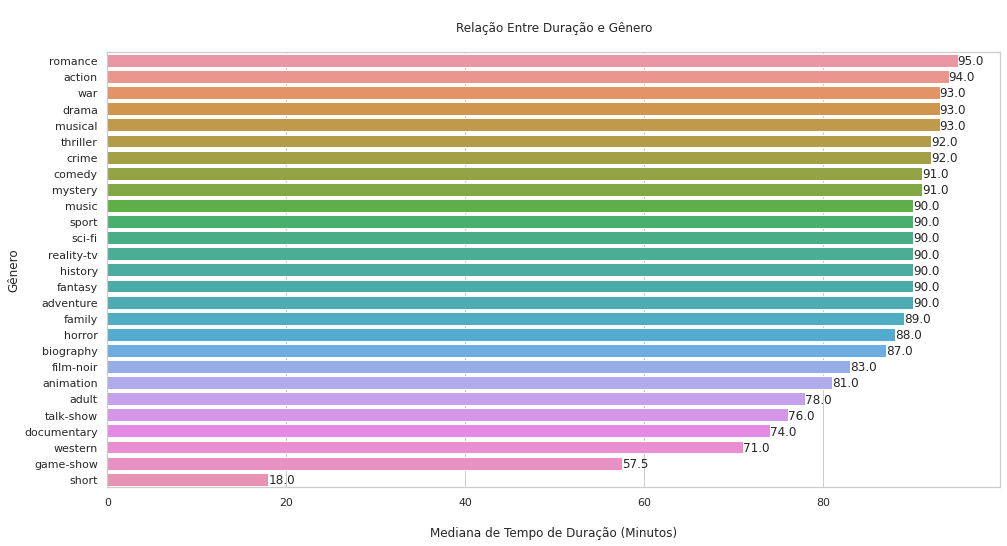

In [71]:
# Plot
# Tamanho da figura
plt.figure(figsize = (16,8))

# Barplot
sns.barplot(y = df_genero_runtime.genre, x = df_genero_runtime.runtime, orient = "h")

# Loop
for i in range(len(df_genero_runtime.index)):
    plt.text(df_genero_runtime.runtime[df_genero_runtime.index[i]],
             i + 0.25,
             round(df_genero_runtime["runtime"][df_genero_runtime.index[i]], 2))

plt.ylabel('Gênero')             
plt.xlabel('\nMediana de Tempo de Duração (Minutos)')
plt.title('\nRelação Entre Duração e Gênero\n')
plt.show()

## 8- Qual o Número de Filmes Produzidos Por País?

Número de filmes produzidos por país.

In [72]:
# Consulta SQL
consulta8 = '''
            SELECT region, COUNT(*) Number_of_movies FROM 
            akas JOIN titles ON 
            akas.title_id = titles.title_id
            WHERE region != 'None'
            AND type = \'movie\'
            GROUP BY region
            ''' 

In [74]:
# Resultado
resultado8 = pd.read_sql_query(consulta8, conn)
display(resultado8)

,region,Number_of_movies
0,AD,22
1,AE,6710
2,AF,113
3,AG,12
4,AL,1290
...,...,...
229,YUCS,153
230,ZA,3280
231,ZM,15
232,ZRCD,2


In [76]:
#Vendo um pouco dessa query
# Shape
resultado8.shape


(234, 2)

In [77]:
# Número de linhas
resultado8.shape[0]

234

In [78]:
# Listas auxiliares
nomes_paises = []
contagem = []

In [79]:
# Esse loop vai me auxiliar a obter o país de acordo com a região
for i in range(resultado8.shape[0]):
    try:
        coun = resultado8['region'].values[i]
        nomes_paises.append(pycountry.countries.get(alpha_2 = coun).name)
        contagem.append(resultado8['Number_of_movies'].values[i])
    except: 
        continue

In [80]:
# Prepara o dataframe
df_filmes_paises = pd.DataFrame()
df_filmes_paises['country'] = nomes_paises
df_filmes_paises['Movie_Count'] = contagem

In [81]:
# Ordena o resultado
df_filmes_paises = df_filmes_paises.sort_values(by = 'Movie_Count', ascending = False)

In [82]:
# Visualiza
df_filmes_paises.head(10)

,country,Movie_Count
199,United States,312496
65,United Kingdom,159987
96,Japan,91655
63,France,85204
89,India,82042
32,Canada,78722
47,Germany,71205
58,Spain,65931
26,Brazil,65822
93,Italy,65773


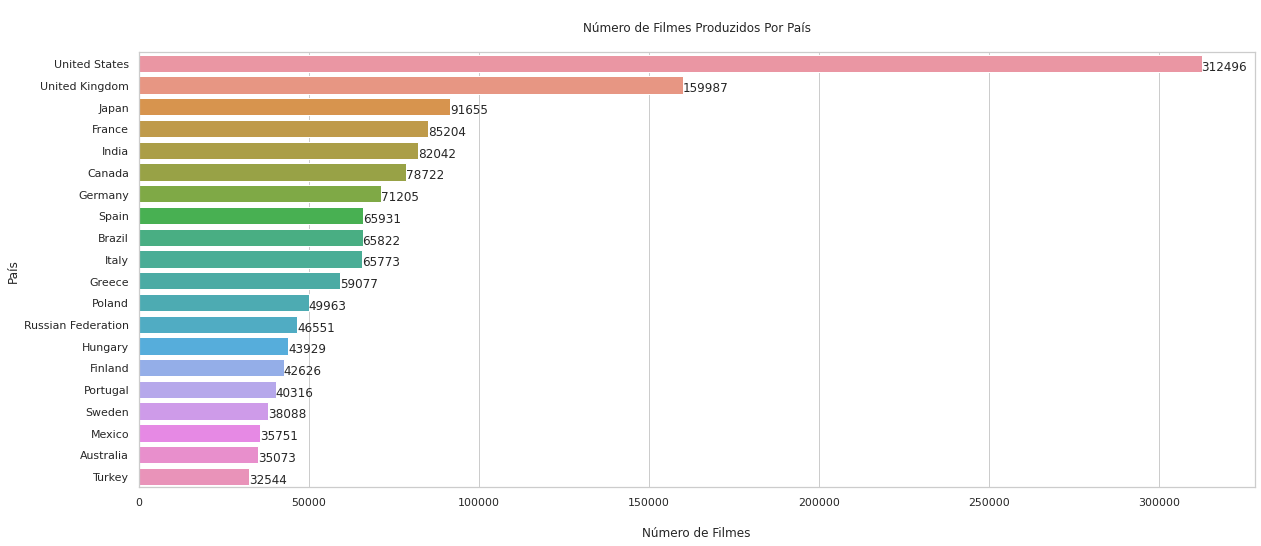

In [83]:
# Plot

# Figura
plt.figure(figsize = (20,8))

# Barplot
sns.barplot(y = df_filmes_paises[:20].country, x = df_filmes_paises[:20].Movie_Count, orient = "h")

# Loop
for i in range(0,20):
    plt.text(df_filmes_paises.Movie_Count[df_filmes_paises.index[i]]-1,
             i + 0.30,
             round(df_filmes_paises["Movie_Count"][df_filmes_paises.index[i]],2))

plt.ylabel('País')             
plt.xlabel('\nNúmero de Filmes')
plt.title('\nNúmero de Filmes Produzidos Por País\n')
plt.show()

## 9- Quais São os Top 10 Melhores Filmes?

Top 10 filmes com melhor avaliação e mais de 25 mil votos.

In [84]:
# Consulta SQL
consulta9 = '''
            SELECT primary_title AS Movie_Name, genres, rating
            FROM 
            titles JOIN ratings
            ON  titles.title_id = ratings.title_id
            WHERE titles.type = 'movie' AND ratings.votes >= 25000
            ORDER BY rating DESC
            LIMIT 10          
            ''' 

In [86]:
# Resultado
top10_melhores_filmes = pd.read_sql_query(consulta9, conn)
display(top10_melhores_filmes)

,Movie_Name,genres,rating
0,The Shawshank Redemption,Drama,9.3
1,The Chaos Class,"Comedy,Drama",9.3
2,The Godfather,"Crime,Drama",9.2
3,12 Angry Men,"Crime,Drama",9.0
4,The Godfather: Part II,"Crime,Drama",9.0
5,Schindler's List,"Biography,Drama,History",9.0
6,The Lord of the Rings: The Return of the King,"Action,Adventure,Drama",9.0
7,The Dark Knight,"Action,Crime,Drama",9.0
8,Mirror Game,"Crime,Mystery,Thriller",9.0
9,Pulp Fiction,"Crime,Drama",8.9


## 10- Quais São os Top 10 Piores Filmes?

Top 10 filmes com pior avaliação e mais de 25 mil votos.

In [87]:
# Consulta SQL
consulta10 = '''
            SELECT primary_title AS Movie_Name, genres, rating
            FROM 
            titles JOIN ratings
            ON  titles.title_id = ratings.title_id
            WHERE titles.type = 'movie' AND ratings.votes >= 25000
            ORDER BY rating ASC
            LIMIT 10
            ''' 

In [88]:
# Resultado
top10_piores_filmes = pd.read_sql_query(consulta10, conn)

In [89]:
display(top10_piores_filmes)


,Movie_Name,genres,rating
0,Reis,"Biography,Drama",1.0
1,Cumali Ceber,Comedy,1.0
2,Sadak 2,"Action,Drama",1.1
3,Smolensk,"Drama,Thriller",1.2
4,Superbabies: Baby Geniuses 2,"Comedy,Family,Sci-Fi",1.5
5,The Cost of Deception,"Crime,Drama,History",1.5
6,Manos: The Hands of Fate,Horror,1.6
7,Justin Bieber: Never Say Never,"Documentary,Music",1.6
8,From Justin to Kelly,"Comedy,Musical,Romance",1.9
9,The Hottie & the Nottie,"Comedy,Romance",1.9


## Por hoje é só isso!